In [18]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
path= "/Users/mustafashirzad/Desktop/Github/Oil Demand/oil.csv"
oil= pd.read_csv(path)

#creat change variables for oil, copper price, dollar values and treasury bond 
oil['chng_logoil'] = oil['wti'].apply(lambda x: np.log(x)) - oil['wti'].shift(1).apply(lambda x: np.log(x))
oil['chng_logcopper'] = oil['copper'].apply(lambda x: np.log(x)) - oil['copper'].shift(1).apply(lambda x: np.log(x))
oil['chng_logdollar'] = oil['dollar'].apply(lambda x: np.log(x)) - oil['dollar'].shift(1).apply(lambda x: np.log(x))
oil['chng_treasury'] = oil['tenyear'] - oil['tenyear'].shift(1)
oil['date'] = pd.to_datetime(oil['date'], format="%m/%d/%Y")
oil.head()

#filter the data for relvent period to run the regression
oil_sample = oil[(oil['date'] >= '2011-06-01') & (oil['date'] <= '2014-06-01')]
oil_sample.head()

,date,tenyear,sp500,wti,copper,dollar,chng_logoil,chng_logcopper,chng_logdollar,chng_treasury
1,2011-06-01,2.96,1314.5500,100.13,409.50,932.16,-0.024661,-0.023530,0.002460,-0.09
2,2011-06-02,3.04,1312.9399,100.54,409.70,927.79,0.004086,0.000488,-0.004699,0.08
3,2011-06-03,2.99,1300.1600,100.49,412.40,922.76,-0.000497,0.006569,-0.005436,-0.05
4,2011-06-06,3.01,1286.1700,98.85,412.25,925.77,-0.016455,-0.000364,0.003257,0.02
5,2011-06-07,3.01,1284.9399,98.98,414.65,921.77,0.001314,0.005805,-0.004330,0.00


In [12]:
#regression of oil price on factors for the sample
import statsmodels.api as sm
X = oil_sample[['chng_logcopper', 'chng_logdollar', 'chng_treasury']]
y = oil_sample['chng_logoil']
regression = sm.OLS(y, sm.add_constant(X)).fit()

# Calculate Newey-West standard errors with lag = 5
robust_se = regression.get_robustcov_results(cov_type='HAC', maxlags=5)
print(robust_se.summary())


                            OLS Regression Results                            
Dep. Variable:            chng_logoil   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     60.63
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           4.19e-35
Time:                        14:01:59   Log-Likelihood:                 2266.5
No. Observations:                 754   AIC:                            -4525.
Df Residuals:                     750   BIC:                            -4507.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.000      0.

In [20]:
#now out of sample data for the rest of the date after 2014
out_of_sample_data = oil[oil['date'] >= '2014-06-02'][['date', 'chng_logcopper', 'chng_logdollar', 'chng_treasury']]

X_out_of_sample = out_of_sample_data[['chng_logcopper', 'chng_logdollar', 'chng_treasury']]
X_out_of_sample = sm.add_constant(X_out_of_sample)

# Get predictions
out_of_sample_predictions = regression.predict(X_out_of_sample)
print(out_of_sample_predictions)

#specify variables for out of smaple predicted oil price, 
initial_log_oil_price = np.log(oil_sample['wti'].iloc[-1])
out_of_sample_data['predicted_chng_logoil'] = out_of_sample_predictions

# Calculate predicted log oil prices
out_of_sample_data['predicted_log_oil_price'] = np.cumsum(out_of_sample_data['predicted_chng_logoil']) + initial_log_oil_price

# Calculate predicted oil prices
out_of_sample_data['predicted_oil_price'] = np.exp(out_of_sample_data['predicted_log_oil_price'])


755     0.005546
756     0.000950
757    -0.006013
758     0.001825
759    -0.003749
          ...   
1178    0.007551
1179   -0.011051
1180   -0.004721
1181   -0.007801
1182   -0.002787
Length: 428, dtype: float64


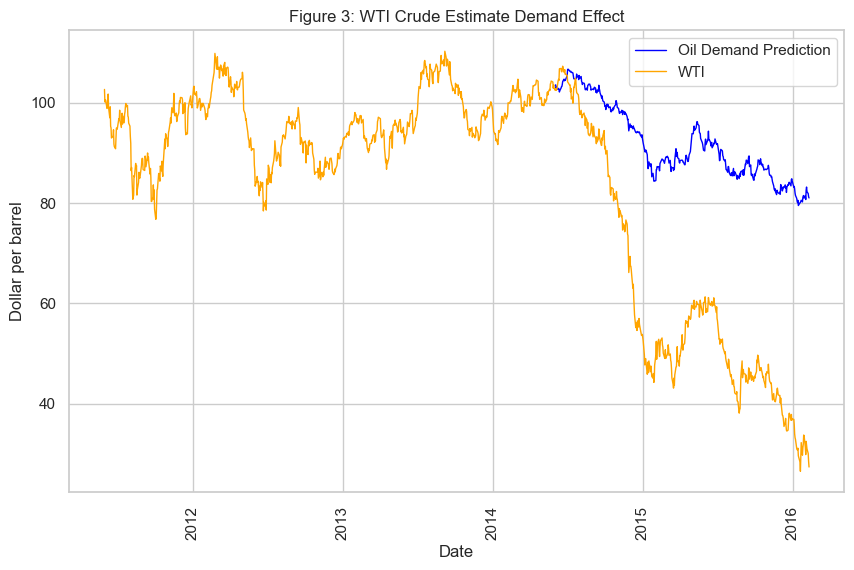

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'out_of_sample_data' and 'oil' are your DataFrames

# Set the style
sns.set(style="whitegrid")

# Plot the lines
plt.figure(figsize=(10, 6))
sns.lineplot(data=out_of_sample_data, x='date', y='predicted_oil_price', label='Oil Demand Prediction', color='blue', linewidth=1)
sns.lineplot(data=oil, x='date', y='wti', label='WTI', color='orange', linewidth=1)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Dollar per barrel')
plt.title('Figure 3: WTI Crude Estimate Demand Effect')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.legend()

# Show the plot
plt.show()
